""""Executive Summary

The solution is basically a lightgbm regression model optimize with rf (random forst) regression and the post prediction of the test is aggregated using sum of the prediction across the test set.

Treated Missing Values by dropping nan values

Generated new features by doing feature engineering.

Remove Outliers
FEATURE SELECTION was performed 

The model is built using Ligthgbm with 5 Kfold cross validation and the prediction test set is aggregated across various the row_id.


What work

Using random forest regression objectives

Post process the test set prediction using Sum

What did not work

Groupby aggregate features


Author: OLUBAYODE EBENEZER         """"



In [1]:

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
import sweetviz as sv
from tabulate import tabulate
import seaborn as sns
import os
import time
import sklearn
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold
from sklearn import metrics
from sklearn.model_selection import GroupKFold, RepeatedKFold, KFold

%matplotlib inline

In [2]:
print('pandas_version ' + pd.__version__)
print('scikit_learn_version ' + sklearn.__version__)
print('lightgbm_version ' +lgb.__version__)

pandas_version 1.4.2
scikit_learn_version 1.1.3
lightgbm_version 3.3.3


In [3]:
## Machine learning model
from lightgbm import LGBMRegressor

## Loading Data

In [4]:
train = pd.read_csv('train_IxoE5JN.csv')
test = pd.read_csv('test_WudNWDM.csv') 
ss = pd.read_csv("sample_submission_jn0a7vR.csv") 
submission = pd.read_csv('sample_submission_jn0a7vR.csv')

In [5]:
train.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


In [6]:
max(train.datetime) #maximum date of which a customer has enrolled on spent with the company

'2018-12-31 23:00:00'

In [7]:
test.head()

,row_id,datetime
0,94993,2019-01-01 00:00:00
1,94994,2019-01-01 01:00:00
2,94995,2019-01-01 02:00:00
3,94996,2019-01-01 03:00:00
4,94997,2019-01-01 04:00:00


In [8]:
ss.head()

,row_id,energy
0,94993,1702.995014
1,94994,1702.995014
2,94995,1702.995014
3,94996,1702.995014
4,94997,1702.995014


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row_id    94992 non-null  int64  
 1   datetime  94992 non-null  object 
 2   energy    93092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26304 non-null  int64 
 1   datetime  26304 non-null  object
dtypes: int64(1), object(1)
memory usage: 411.1+ KB


In [11]:
def quality_report(df):
    """
    Description: Displays quality of data in terms of missing values, 
    unique numbers, datatypes etc.
    
    Arguments: Dataframe
    """
    dtypes = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    quality_df  = pd.concat([total, percent, nuniq, dtypes], axis=1, keys=['Total NaN', 'Percent of NaN','Nunique', 'Dtype'])
    display(quality_df)


In [12]:
quality_report(train)

,Total NaN,Percent of NaN,Nunique,Dtype
energy,1900,2.000168,61308,float64
row_id,0,0.000000,94992,int64
datetime,0,0.000000,94992,object


there is 2% Null values in Train data which needed to be filled

In [13]:
quality_report(test)

,Total NaN,Percent of NaN,Nunique,Dtype
row_id,0,0.0,26304,int64
datetime,0,0.0,26304,object


## Energy Variable Distribution

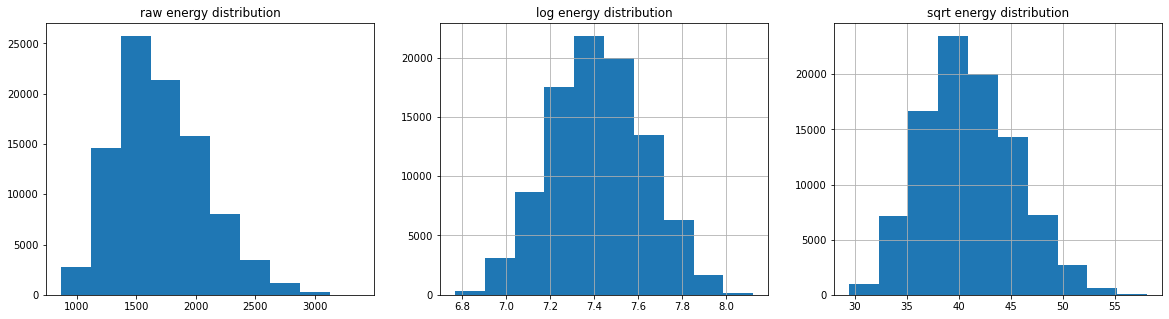

In [14]:
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 3, 1) 
plt.hist(data = train, x = 'energy');

plt.title('raw energy distribution')
plt.subplot(1, 3, 2)
np.log1p(train['energy']).hist();

plt.title('log energy distribution')
plt.subplot(1, 3, 3)
np.sqrt(train['energy']).hist();
plt.title('sqrt energy distribution');

In [15]:
train.dropna(axis= 0, inplace =True)

In [16]:
quality_report(train)

,Total NaN,Percent of NaN,Nunique,Dtype
row_id,0,0.0,93092,int64
datetime,0,0.0,93092,object
energy,0,0.0,61308,float64


In [17]:
train['datetime'].unique()

array(['2008-03-01 00:00:00', '2008-03-01 01:00:00',
       '2008-03-01 02:00:00', ..., '2018-12-31 21:00:00',
       '2018-12-31 22:00:00', '2018-12-31 23:00:00'], dtype=object)

In [18]:
test['datetime'].unique()

array(['2019-01-01 00:00:00', '2019-01-01 01:00:00',
       '2019-01-01 02:00:00', ..., '2021-12-31 21:00:00',
       '2021-12-31 22:00:00', '2021-12-31 23:00:00'], dtype=object)

In [19]:
train['energy'].describe().round(3)

count    93092.000
mean      1702.995
std        369.322
min        866.389
25%       1431.541
50%       1654.466
75%       1935.993
max       3374.400
Name: energy, dtype: float64

# I observe 0% of the energy values are 866.389.

# FEATURES ENGINEERING

In [20]:
max(train.datetime) #maximum date of which total energy demand on an hourly basis

'2018-12-31 23:00:00'

In [21]:
import datetime as dt

In [22]:
#Converting to datetime object for easy data preprocessing i.e pd.to_datetime(train['datetime'], format='%Y/%m/%d') 
train['datetime'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d %H:%M:%S') #, errors = 'coerce')
train['datetime'].dtypes
time_ = train['datetime'].iloc[0]
time_

Timestamp('2008-03-01 00:00:00')

In [23]:
train['year'] = train.datetime.dt.year  #Extracting year
train['month'] = train.datetime.dt.month # Extracting month  
train['quater'] = train.datetime.dt.quarter # Extracting quarter
train['day_of_week'] = train['datetime'].apply(lambda x: x.dayofweek)
train['day_of_year'] = train['datetime'].apply(lambda x: x.dayofyear)
train['week_of_year'] = train['datetime'].apply(lambda x: x.weekofyear)
train['HourRecoreded'] = train['datetime'].apply(lambda x: x.hour)


today = pd.to_datetime('2019-1-1') # setting the current date close to the date of which the last total energy demanded on an hourly  which is 2018-12-31

#Getting the no of days, month when the total energy demanded hourly and now 
train['duration_hours'] = (today - train['datetime']).dt.seconds/3600  #No of hours of which total energy demanded on an hourly in the country
train['duration_days'] = (today - train['datetime']).dt.days  #No of days of which total energy demanded on an hourly in the country 
train['duration_months'] = ((today- train.datetime)/np.timedelta64(1, 'M'))  #No of months of which total energy demanded on an hourly in the country
train['duration_months'] =  train['duration_months'].astype(int)
train['duration_year'] = ((today- train.datetime)/np.timedelta64(1, 'Y'))
train['duration_year'] =  train['duration_year'].astype(int)

#Getting information of total energy demanded  at the start of the month and at the end of the month
train['is_month_end'] = train.datetime.dt.is_month_end.astype(int)
train['is_month_start'] = train.datetime.dt.is_month_start.astype(int)
train['is_quarter_end'] = train.datetime.dt.is_quarter_end.astype(int)
train['is_quarter_start'] = train.datetime.dt.is_quarter_start.astype(int)
train['is_year_end'] = train.datetime.dt.is_year_end.astype(int)
train['is_year_start'] = train.datetime.dt.is_year_start.astype(int)




In [24]:
max(test.datetime) #maximum date of which total energy demand on an hourly basis

'2021-12-31 23:00:00'

In [25]:
#Converting to datetime object for easy data preprocessing i.e pd.to_datetime(test['datetime'], format='%Y/%m/%d') 
test['datetime'] = pd.to_datetime(test['datetime'], format='%Y-%m-%d %H:%M:%S') #, errors = 'coerce')
test['datetime'].dtypes
Time = test['datetime'].iloc[0]
Time

Timestamp('2019-01-01 00:00:00')

In [26]:
test['year'] = test.datetime.dt.year  #Extracting year
test['month'] = test.datetime.dt.month # Extracting month  
test['quater'] = test.datetime.dt.quarter # Extracting quarter
test['day_of_week'] = test['datetime'].apply(lambda x: x.dayofweek)
test['day_of_year'] = test['datetime'].apply(lambda x: x.dayofyear)
test['week_of_year'] = test['datetime'].apply(lambda x: x.weekofyear)
test['HourRecoreded'] = test['datetime'].apply(lambda x: x.hour)


today_ = pd.to_datetime('2022-1-1') # setting the current date close to the date of which the last total energy demanded on an hourly  which is 2018-12-31

#Getting the no of days, month when the total energy demanded hourly and now 
test['duration_hours'] = (today_ - test['datetime']).dt.seconds/3600  #No of hours of which total energy demanded on an hourly in the country
test['duration_days'] = (today_ - test['datetime']).dt.days  #No of days of which total energy demanded on an hourly in the country 
test['duration_months'] = ((today_- test.datetime)/np.timedelta64(1, 'M'))  #No of months of which total energy demanded on an hourly in the country
test['duration_months'] =  test['duration_months'].astype(int) 
test['duration_year'] = ((today- test.datetime)/np.timedelta64(1, 'Y'))
test['duration_year'] =  test['duration_year'].astype(int)

#Getting information of total energy demanded  at the start of the month and at the end of the month
test['is_month_end'] = test.datetime.dt.is_month_end.astype(int)
test['is_month_start'] = test.datetime.dt.is_month_start.astype(int)
test['is_quarter_end'] = test.datetime.dt.is_quarter_end.astype(int)
test['is_quarter_start'] = test.datetime.dt.is_quarter_start.astype(int)
test['is_year_end'] = test.datetime.dt.is_year_end.astype(int)
test['is_year_start'] = test.datetime.dt.is_year_start.astype(int)

#

In [27]:
train.head()

,row_id,datetime,energy,year,month,quater,day_of_week,day_of_year,week_of_year,HourRecoreded,duration_hours,duration_days,duration_months,duration_year,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,1,2008-03-01 00:00:00,1259.985563,2008,3,1,5,61,9,0,0.0,3958,130,10,0,1,0,0,0,0
1,2,2008-03-01 01:00:00,1095.541500,2008,3,1,5,61,9,1,23.0,3957,130,10,0,1,0,0,0,0
2,3,2008-03-01 02:00:00,1056.247500,2008,3,1,5,61,9,2,22.0,3957,130,10,0,1,0,0,0,0
3,4,2008-03-01 03:00:00,1034.742000,2008,3,1,5,61,9,3,21.0,3957,130,10,0,1,0,0,0,0
4,5,2008-03-01 04:00:00,1026.334500,2008,3,1,5,61,9,4,20.0,3957,130,10,0,1,0,0,0,0


In [28]:
test.head()

,row_id,datetime,year,month,quater,day_of_week,day_of_year,week_of_year,HourRecoreded,duration_hours,duration_days,duration_months,duration_year,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,94993,2019-01-01 00:00:00,2019,1,1,1,1,1,0,0.0,1096,36,0,0,1,0,1,0,1
1,94994,2019-01-01 01:00:00,2019,1,1,1,1,1,1,23.0,1095,36,0,0,1,0,1,0,1
2,94995,2019-01-01 02:00:00,2019,1,1,1,1,1,2,22.0,1095,36,0,0,1,0,1,0,1
3,94996,2019-01-01 03:00:00,2019,1,1,1,1,1,3,21.0,1095,36,0,0,1,0,1,0,1
4,94997,2019-01-01 04:00:00,2019,1,1,1,1,1,4,20.0,1095,36,0,0,1,0,1,0,1


In [29]:
train['duration_days'].unique()

array([3958, 3957, 3956, ...,    2,    1,    0], dtype=int64)

In [30]:
train['duration_days'].value_counts()

307     24
141     24
2179    24
2178    24
2177    24
        ..
2088    20
3087    20
1875    20
1496    19
3958     1
Name: duration_days, Length: 3959, dtype: int64

In [31]:
train['duration_hours'].unique()

array([ 0., 23., 22., 21., 20., 19., 18., 17., 16., 15., 14., 13., 12.,
       11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.])

In [32]:
quality_report(train)

,Total NaN,Percent of NaN,Nunique,Dtype
row_id,0,0.0,93092,int64
datetime,0,0.0,93092,datetime64[ns]
is_year_end,0,0.0,2,int32
is_quarter_start,0,0.0,2,int32
is_quarter_end,0,0.0,2,int32
is_month_start,0,0.0,2,int32
is_month_end,0,0.0,2,int32
duration_year,0,0.0,11,int32
duration_months,0,0.0,131,int32
duration_days,0,0.0,3959,int64


In [33]:
quality_report(test)

,Total NaN,Percent of NaN,Nunique,Dtype
row_id,0,0.0,26304,int64
duration_days,0,0.0,1097,int64
is_year_end,0,0.0,2,int32
is_quarter_start,0,0.0,2,int32
is_quarter_end,0,0.0,2,int32
is_month_start,0,0.0,2,int32
is_month_end,0,0.0,2,int32
duration_year,0,0.0,4,int32
duration_months,0,0.0,37,int32
duration_hours,0,0.0,24,float64


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93092 entries, 0 to 94991
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   row_id            93092 non-null  int64         
 1   datetime          93092 non-null  datetime64[ns]
 2   energy            93092 non-null  float64       
 3   year              93092 non-null  int64         
 4   month             93092 non-null  int64         
 5   quater            93092 non-null  int64         
 6   day_of_week       93092 non-null  int64         
 7   day_of_year       93092 non-null  int64         
 8   week_of_year      93092 non-null  int64         
 9   HourRecoreded     93092 non-null  int64         
 10  duration_hours    93092 non-null  float64       
 11  duration_days     93092 non-null  int64         
 12  duration_months   93092 non-null  int32         
 13  duration_year     93092 non-null  int32         
 14  is_month_end      9309

In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   row_id            26304 non-null  int64         
 1   datetime          26304 non-null  datetime64[ns]
 2   year              26304 non-null  int64         
 3   month             26304 non-null  int64         
 4   quater            26304 non-null  int64         
 5   day_of_week       26304 non-null  int64         
 6   day_of_year       26304 non-null  int64         
 7   week_of_year      26304 non-null  int64         
 8   HourRecoreded     26304 non-null  int64         
 9   duration_hours    26304 non-null  float64       
 10  duration_days     26304 non-null  int64         
 11  duration_months   26304 non-null  int32         
 12  duration_year     26304 non-null  int32         
 13  is_month_end      26304 non-null  int32         
 14  is_month_start    2630

In [36]:
train.drop('datetime', axis=1, inplace=True)

In [37]:
test.drop('datetime', axis=1, inplace=True)

In [38]:
# new_data['year_month'] = 
train['year_month'] = train['year'].apply(str) + "_"  + train['month'].apply(str) #Feting the strings total number of total energy that recorded each month of the year by using categorically method

In [39]:
# new_data['year_month'] = 
test['year_month'] = test['year'].apply(str) + "_"  + test['month'].apply(str) #Feting the strings total number of total energy that recorded each month of the year by using categorically method

In [40]:
train['year_month'].head()

0    2008_3
1    2008_3
2    2008_3
3    2008_3
4    2008_3
Name: year_month, dtype: object

In [41]:
train['year_month'].unique()

array(['2008_3', '2008_4', '2008_5', '2008_6', '2008_7', '2008_8',
       '2008_9', '2008_10', '2008_11', '2008_12', '2009_1', '2009_2',
       '2009_3', '2009_4', '2009_5', '2009_6', '2009_7', '2009_8',
       '2009_9', '2009_10', '2009_11', '2009_12', '2010_1', '2010_2',
       '2010_3', '2010_4', '2010_5', '2010_6', '2010_7', '2010_8',
       '2010_9', '2010_10', '2010_11', '2010_12', '2011_1', '2011_2',
       '2011_3', '2011_4', '2011_5', '2011_6', '2011_7', '2011_8',
       '2011_9', '2011_10', '2011_11', '2011_12', '2012_1', '2012_2',
       '2012_3', '2012_4', '2012_5', '2012_6', '2012_7', '2012_8',
       '2012_9', '2012_10', '2012_11', '2012_12', '2013_1', '2013_2',
       '2013_3', '2013_4', '2013_5', '2013_6', '2013_7', '2013_8',
       '2013_9', '2013_10', '2013_11', '2013_12', '2014_1', '2014_2',
       '2014_3', '2014_4', '2014_5', '2014_6', '2014_7', '2014_8',
       '2014_9', '2014_10', '2014_11', '2014_12', '2015_1', '2015_2',
       '2015_3', '2015_4', '2015_5', '201

In [42]:
type(train['year_month'])

pandas.core.series.Series

In [43]:
type(test['year_month'])

pandas.core.series.Series

In [44]:
train['year_month_int'], _ = pd.factorize(train['year_month']) # label encoding 

In [45]:
test['year_month_int'], _ = pd.factorize(test['year_month']) # label encoding 

In [46]:
train['year_month_int'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
      dtype=int64)

In [47]:
train.head()

,row_id,energy,year,month,quater,day_of_week,day_of_year,week_of_year,HourRecoreded,duration_hours,...,duration_months,duration_year,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,year_month,year_month_int
0,1,1259.985563,2008,3,1,5,61,9,0,0.0,...,130,10,0,1,0,0,0,0,2008_3,0
1,2,1095.541500,2008,3,1,5,61,9,1,23.0,...,130,10,0,1,0,0,0,0,2008_3,0
2,3,1056.247500,2008,3,1,5,61,9,2,22.0,...,130,10,0,1,0,0,0,0,2008_3,0
3,4,1034.742000,2008,3,1,5,61,9,3,21.0,...,130,10,0,1,0,0,0,0,2008_3,0
4,5,1026.334500,2008,3,1,5,61,9,4,20.0,...,130,10,0,1,0,0,0,0,2008_3,0


In [48]:
train['duration_hours'].value_counts()

19.0    3894
7.0     3891
1.0     3888
20.0    3887
5.0     3886
11.0    3886
16.0    3885
21.0    3884
13.0    3882
3.0     3882
12.0    3882
2.0     3881
0.0     3881
9.0     3879
8.0     3878
17.0    3876
22.0    3875
14.0    3874
23.0    3872
6.0     3872
4.0     3872
15.0    3863
10.0    3862
18.0    3860
Name: duration_hours, dtype: int64

In [49]:
# bin_label = [1,2,3,4,5]
train['duration_hours_bin'] = pd.qcut(train.duration_hours, q = [0, .2, .4, .6, .8, 1], labels=False) #Arranginging 'duration_hours in percentile of 20% increasing, Bin is done to convert your continous data into group data 
# bin_label = [1,2,3,4,5]
test['duration_hours_bin'] = pd.qcut(test.duration_hours, q = [0, .2, .4, .6, .8, 1], labels=False) #Arranginging 'duration_hours in percentile of 20% increasing, Bin is done to convert your continous data into group data 

In [50]:
train['duration_hours_bin'].unique()

array([0, 4, 3, 2, 1], dtype=int64)

In [51]:
train['duration_hours_bin'].head()

0    0
1    4
2    4
3    4
4    4
Name: duration_hours_bin, dtype: int64

In [52]:
train['duration_hours_bin'].value_counts()

1    19406
0    19404
2    19386
3    19378
4    15518
Name: duration_hours_bin, dtype: int64

In [53]:
train['duration_hours_bin'].value_counts() # Calculating mean, std, max, min for each of the duration_hour groups e.g the mean of all the customer that makes a purchase in a month and in year e.t.c

train['duration_hours' + '_mean_on_yr_mth'] =train['duration_hours'].groupby(train['year_month']).transform('mean')
train['duration_hours' + '_std_on_yr_mth'] = train['duration_hours'].groupby(train['year_month']).transform('std')
train['duration_hours' + '_max_on_yr_mth'] =train['duration_hours'].groupby(train['year_month']).transform('max')
train['duration_hours' + '_min_on_yr_mth'] = train['duration_hours'].groupby(train['year_month']).transform('min')

In [54]:
test['duration_hours_bin'].value_counts() # Calculating mean, std, max, min for each of the duration_hour groups e.g the mean of all the customer that makes a purchase in a month and in year e.t.c

test['duration_hours' + '_mean_on_yr_mth'] =test['duration_hours'].groupby(test['year_month']).transform('mean')
test['duration_hours' + '_std_on_yr_mth'] = test['duration_hours'].groupby(test['year_month']).transform('std')
test['duration_hours' + '_max_on_yr_mth'] =test['duration_hours'].groupby(test['year_month']).transform('max')
test['duration_hours' + '_min_on_yr_mth'] = test['duration_hours'].groupby(test['year_month']).transform('min')

In [55]:
train.head()

,row_id,energy,year,month,quater,day_of_week,day_of_year,week_of_year,HourRecoreded,duration_hours,...,is_quarter_start,is_year_end,is_year_start,year_month,year_month_int,duration_hours_bin,duration_hours_mean_on_yr_mth,duration_hours_std_on_yr_mth,duration_hours_max_on_yr_mth,duration_hours_min_on_yr_mth
0,1,1259.985563,2008,3,1,5,61,9,0,0.0,...,0,0,0,2008_3,0,0,11.528689,6.918363,23.0,0.0
1,2,1095.541500,2008,3,1,5,61,9,1,23.0,...,0,0,0,2008_3,0,4,11.528689,6.918363,23.0,0.0
2,3,1056.247500,2008,3,1,5,61,9,2,22.0,...,0,0,0,2008_3,0,4,11.528689,6.918363,23.0,0.0
3,4,1034.742000,2008,3,1,5,61,9,3,21.0,...,0,0,0,2008_3,0,4,11.528689,6.918363,23.0,0.0
4,5,1026.334500,2008,3,1,5,61,9,4,20.0,...,0,0,0,2008_3,0,4,11.528689,6.918363,23.0,0.0


In [56]:
train.tail()

,row_id,energy,year,month,quater,day_of_week,day_of_year,week_of_year,HourRecoreded,duration_hours,...,is_quarter_start,is_year_end,is_year_start,year_month,year_month_int,duration_hours_bin,duration_hours_mean_on_yr_mth,duration_hours_std_on_yr_mth,duration_hours_max_on_yr_mth,duration_hours_min_on_yr_mth
94987,94988,2528.4468,2018,12,4,0,365,1,19,5.0,...,0,1,0,2018_12,129,1,11.503429,6.940905,23.0,0.0
94988,94989,2461.8836,2018,12,4,0,365,1,20,4.0,...,0,1,0,2018_12,129,0,11.503429,6.940905,23.0,0.0
94989,94990,2365.9944,2018,12,4,0,365,1,21,3.0,...,0,1,0,2018_12,129,0,11.503429,6.940905,23.0,0.0
94990,94991,2342.9428,2018,12,4,0,365,1,22,2.0,...,0,1,0,2018_12,129,0,11.503429,6.940905,23.0,0.0
94991,94992,2180.2176,2018,12,4,0,365,1,23,1.0,...,0,1,0,2018_12,129,0,11.503429,6.940905,23.0,0.0


In [57]:
train['total_day'] = train['day_of_week'] + train['day_of_year'] #
test['total_day'] = test['day_of_week'] + test['day_of_year'] #

In [58]:
train['total_hour'] = train['HourRecoreded'] + train['duration_hours'] #
test['total_hour'] = test['HourRecoreded'] + test['duration_hours'] 

In [59]:
train.shape

(93092, 28)

In [60]:
test.shape

(26304, 27)

In [61]:
train_f =train.drop(['row_id','year_month'], axis=1)

In [62]:
test_f = test.drop(['row_id','year_month'], axis=1)

In [63]:
train_f.shape

(93092, 26)

In [64]:
test_f.shape

(26304, 25)

In [65]:
train_f.head()

,energy,year,month,quater,day_of_week,day_of_year,week_of_year,HourRecoreded,duration_hours,duration_days,...,is_year_end,is_year_start,year_month_int,duration_hours_bin,duration_hours_mean_on_yr_mth,duration_hours_std_on_yr_mth,duration_hours_max_on_yr_mth,duration_hours_min_on_yr_mth,total_day,total_hour
0,1259.985563,2008,3,1,5,61,9,0,0.0,3958,...,0,0,0,0,11.528689,6.918363,23.0,0.0,66,0.0
1,1095.541500,2008,3,1,5,61,9,1,23.0,3957,...,0,0,0,4,11.528689,6.918363,23.0,0.0,66,24.0
2,1056.247500,2008,3,1,5,61,9,2,22.0,3957,...,0,0,0,4,11.528689,6.918363,23.0,0.0,66,24.0
3,1034.742000,2008,3,1,5,61,9,3,21.0,3957,...,0,0,0,4,11.528689,6.918363,23.0,0.0,66,24.0
4,1026.334500,2008,3,1,5,61,9,4,20.0,3957,...,0,0,0,4,11.528689,6.918363,23.0,0.0,66,24.0


In [66]:
train_f.columns

Index(['energy', 'year', 'month', 'quater', 'day_of_week', 'day_of_year',
       'week_of_year', 'HourRecoreded', 'duration_hours', 'duration_days',
       'duration_months', 'duration_year', 'is_month_end', 'is_month_start',
       'is_quarter_end', 'is_quarter_start', 'is_year_end', 'is_year_start',
       'year_month_int', 'duration_hours_bin', 'duration_hours_mean_on_yr_mth',
       'duration_hours_std_on_yr_mth', 'duration_hours_max_on_yr_mth',
       'duration_hours_min_on_yr_mth', 'total_day', 'total_hour'],
      dtype='object')

In [67]:
test_f.columns

Index(['year', 'month', 'quater', 'day_of_week', 'day_of_year', 'week_of_year',
       'HourRecoreded', 'duration_hours', 'duration_days', 'duration_months',
       'duration_year', 'is_month_end', 'is_month_start', 'is_quarter_end',
       'is_quarter_start', 'is_year_end', 'is_year_start', 'year_month_int',
       'duration_hours_bin', 'duration_hours_mean_on_yr_mth',
       'duration_hours_std_on_yr_mth', 'duration_hours_max_on_yr_mth',
       'duration_hours_min_on_yr_mth', 'total_day', 'total_hour'],
      dtype='object')

## Machine Learning model

In [68]:
## The machine learning dependent and independent features
X = train_f.drop('energy', axis=1)
y = train_f['energy']

In [69]:
y.shape

(93092,)

In [70]:
y.head()

0    1259.985563
1    1095.541500
2    1056.247500
3    1034.742000
4    1026.334500
Name: energy, dtype: float64

In [71]:
# params = {
#         "objective" : "quantile",
#     "boosting_type":"rf",
#         "metric" : "rmse",
#         "learning_rate" : 0.087,
#          "sub_feature" : 0.99,
#         "sub_row" : 0.75,
#         "bagging_freq" : 1,
#         "lambda_l2" : 0.8,
#         'verbosity': 1,
#        'num_iterations' : 3000,        
#         'num_leaves': 256,
#         "min_data_in_leaf": 100,
# }


params = {
        "objective" : "quantile",
    "boosting_type":"rf",
        "metric" : "rmse",
        "learning_rate" : 0.0087,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.8,
        'verbosity': 1,
    'max_depth': 200, #100
    "num_boos_round":300,
    "feature_fraction":0.9,
       'num_iterations' : 3000,        
        'num_leaves': 256,
        "min_data_in_leaf": 100,
}

In [72]:
errcb=[]
y_pred_totcb=[]
fold= KFold(n_splits=5, shuffle=True, random_state=1)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m = LGBMRegressor(**params)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",metrics.mean_squared_error(y_test, preds, squared=False))
    errcb.append(metrics.mean_squared_error(y_test, preds, squared=False))
    p = m.predict(test_f)
    y_pred_totcb.append(p)
    
    
# fold=StratifiedKFold(n_splits=5)#15#5#10

# i=1
# for train_index, test_index in fold.split(X_,y_):
        
#     X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
#     y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]

#     model = LGBMClassifier(**params, n_estimators=1000)

#     model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300, verbose = False)#erly100
#     preds=model.predict(X_test)

#     print(f'F1, fold {i}: {f1_score(y_test,preds)}')
#     i+=1                
#     oof_f1.append(f1_score(y_test,preds))
#     p2 = model.predict_proba(test_new)[:, -1]
#     oof_predictions.append(p2)
    

# print(np.mean(oof_f1))

[LightGBM] [Warning] Unknown parameter: num_boos_round
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.75. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.9, sub_feature=0.8 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: num_boos_round
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[Li

In [73]:
np.mean(np.log1p(errcb))

5.855149975230205

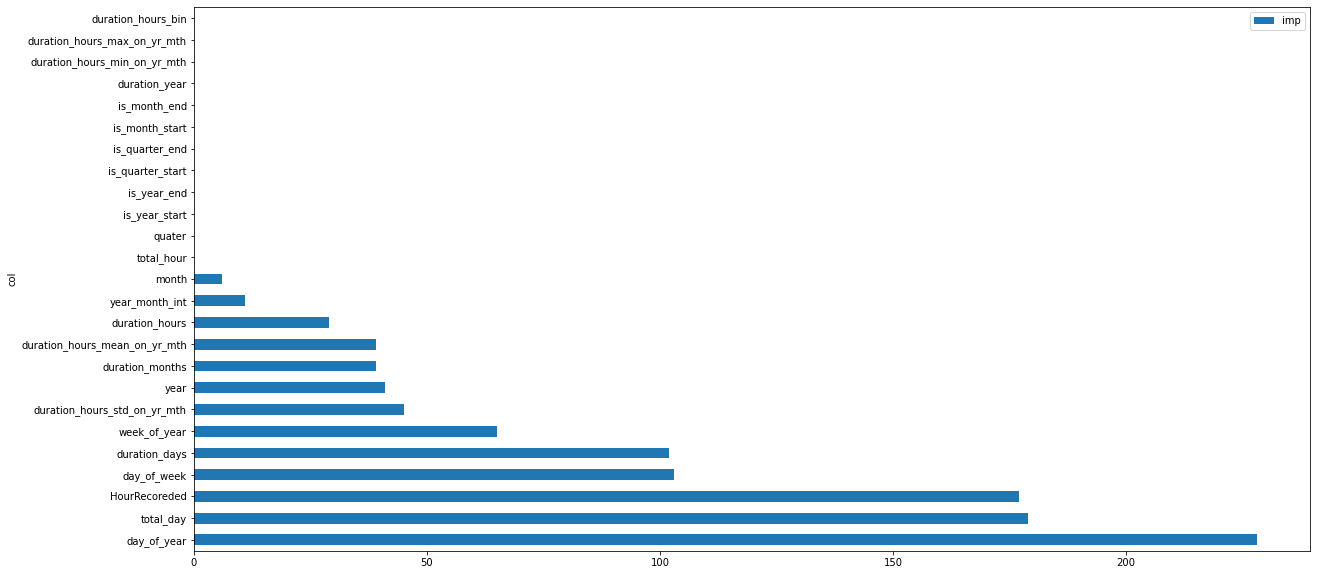

In [74]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png') 

In [75]:
np.mean(y_pred_totcb, 0)

array([1934.16201311, 1909.42940015, 1909.42940015, ..., 2749.38092939,
       2706.9792023 , 2653.72035044])

In [76]:
len(np.mean(y_pred_totcb, 0))

26304

Text(0.5, 1.0, 'Model features importance:')

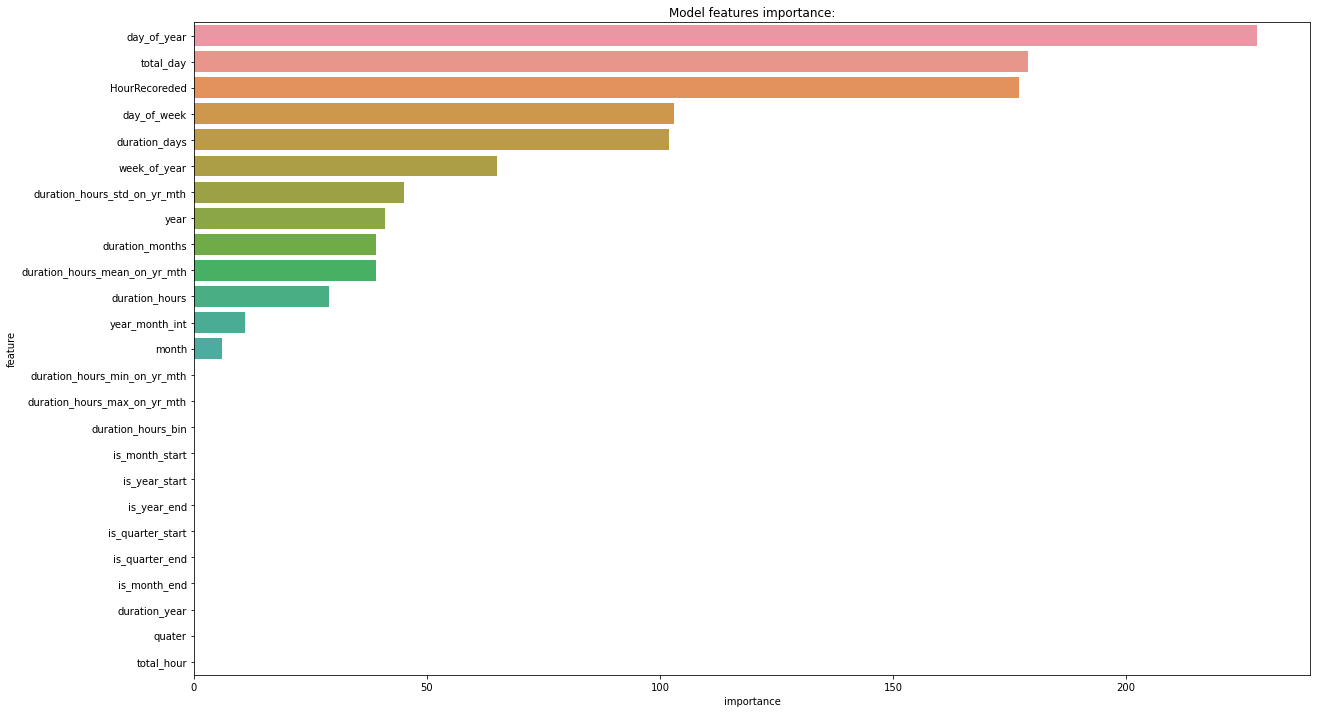

In [77]:
feature_importance_df = pd.DataFrame(m.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('Model features importance:')
# new_feat = fea_imp.sort_values(by = ['importance'], ascending = False).head(50)['feature'].to_list()

## post preprocess the prediction for the test set

In [78]:
test['energy'] = np.mean(y_pred_totcb, 0)

In [79]:
ss = test[['row_id', 'energy']]

In [80]:
ss.head()

,row_id,energy
0,94993,1934.162013
1,94994,1909.429400
2,94995,1909.429400
3,94996,1909.429400
4,94997,1909.429400


In [81]:
# ss.to_csv('energy_quamtile_rf_max_depth_200_ss.csv', index = False)

# Aggregate the prediction across each row_id by their total.

In [82]:
# subt = ss.groupby('row_id')['energy'].sum().reset_index()

In [83]:
subt = ss.groupby('row_id')['energy'].sum().reset_index()

In [84]:
prediction = submission.merge(subt, on='row_id').rename(columns={'energy_y':'energy'}).drop('energy_x', axis=1)

In [85]:
# prediction.to_csv('energy_quantile_rf_aggregate.csv', index = False)

###  FEATURE SELECTION

In [86]:
# prediction['energy'] = np.log1p(abs(prediction['energy']))

In [87]:
# prediction.to_csv('base_lb8_energy.csv', index=False)

In [88]:
new_feat = feature_importance_df.sort_values(by = ['importance'], ascending = False).head(8)['feature'].to_list()

In [89]:
new_feat

['day_of_year',
 'total_day',
 'HourRecoreded',
 'day_of_week',
 'duration_days',
 'week_of_year',
 'duration_hours_std_on_yr_mth',
 'year']

In [90]:
X = train_f[new_feat]
y = train_f['energy']

In [91]:
test_new = test_f[new_feat]

In [92]:


params = {
        "objective" : "quantile",
    "boosting_type":"rf",
        "metric" : "rmse",
        "learning_rate" : 0.087,
         "sub_feature" : 0.99,
        "sub_row" :0.9, #0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.8,
        'verbosity': 1,
    'max_depth': 300, #100
    # "num_boos_round":300,
    "feature_fraction":0.8,
       'num_iterations' : 3000,        
        'num_leaves': 800,
        "min_data_in_leaf": 15,
}

In [93]:
errcb=[]
y_pred_totcb=[]
fold= KFold(n_splits=5, shuffle=True, random_state=1)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m = LGBMRegressor(**params)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",metrics.mean_squared_error(y_test, preds, squared=False))
    errcb.append(metrics.mean_squared_error(y_test, preds, squared=False))
    p = m.predict(test_new)
    y_pred_totcb.append(p)

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.99. Current value: feature_fraction=0.99
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.9. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, sub_feature=0.99 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.99. Current value: feature_fraction=0.99
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.9. Current valu

In [94]:
np.mean(np.log1p(errcb))

5.798880121686254

In [95]:
test['energy'] = np.mean(y_pred_totcb, 0)

In [96]:
ss = test[['row_id', 'energy']]

In [97]:
ss.head()

,row_id,energy
0,94993,1935.676320
1,94994,1934.782409
2,94995,1934.782409
3,94996,1934.782409
4,94997,1934.782409


In [98]:
ss.tail()

,row_id,energy
26299,121292,2867.863030
26300,121293,2857.208826
26301,121294,2857.208826
26302,121295,2836.878705
26303,121296,2485.564271


In [99]:
ss['energy'].unique()

array([1935.67631962, 1934.78240934, 1959.95434437, ..., 2867.86303028,
       2857.20882634, 2836.87870467])

In [100]:
ss.to_csv('energy_testing.csv', index = False)

# Aggregate the prediction across each row_id by their total.

In [101]:
subt = ss.groupby('row_id')['energy'].sum().reset_index()

In [102]:
prediction = submission.merge(subt, on='row_id').rename(columns={'energy_y':'energy'}).drop('energy_x', axis=1)

In [103]:
# prediction.to_csv('energy_quantile_rf_aggregate_feature_selection.csv', index = False)

In [104]:
# prediction['energy'] = np.log1p(abs(prediction['energy']))

In [105]:
# prediction.to_csv('base_lb8_energy.csv', index=False)